# Topics Covered

1. Overview of Data
2. Data Manipulation and Cleaning
3. Basic EDA
    - Summary Stats and Count Plots


#### Data Source

- https://www.divvybikes.com/system-data

#### The Data:

Each trip is anonymized and includes:
    - Trip start day and time
    - Trip end day and time
    - Trip start station
    - Trip end station
    - Rider type (Member, Single Ride, and Day Pass)

The data has been processed to remove trips that are taken by staff as they service and inspect the system; and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it was secure).

## Import libraries, data, and examine data properties

In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np
import calendar
import datetime
from geopy import distance
import pingouin

import folium  #needed for interactive map
from folium.plugins import HeatMap

from   collections           import Counter
from   sklearn               import preprocessing
from   datetime              import datetime
from   collections           import Counter
from   math                  import exp
from   sklearn.linear_model  import LinearRegression as LinReg
from   sklearn.metrics       import mean_absolute_error
from   sklearn.metrics       import median_absolute_error
from   sklearn.metrics       import r2_score

%matplotlib inline
sns.set()

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  gray solid !important;
  color: black !important;
}
</style>

### Import and Examine Data

In [3]:
# import Divvy Stations data
stations = pd.read_csv('Data/Divvy_Bicycle_Stations.csv')
stations.shape

(688, 8)

In [4]:
# import Divvy Trips data using a for loop
trips = pd.read_csv(f'Data/Divvy_Trips_2018_Q2.csv', nrows=0) # this import is just to get the names of the columns
columns = trips.columns
trips = pd.DataFrame() #reset the dataframe to have no data
years_list = [2018, 2019]
quarters_list = ['Q1', 'Q2', 'Q3', 'Q4']

for year in years_list:
    for quarter in quarters_list:
        temp_df = pd.read_csv(f'Data/Divvy_Trips_{year}_{quarter}.csv')
        temp_df.columns = columns
        trips = pd.concat([trips, temp_df], axis=0, ignore_index=True)

In [5]:
# Get an idea of what the trips data looks like
trips.head(3)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,17536702,2018-01-01 00:12:00,2018-01-01 00:17:23,3304,323.0,69,Damen Ave & Pierce Ave,159,Claremont Ave & Hirsch St,Subscriber,Male,1988.0
1,17536703,2018-01-01 00:41:35,2018-01-01 00:47:52,5367,377.0,253,Winthrop Ave & Lawrence Ave,325,Clark St & Winnemac Ave (Temp),Subscriber,Male,1984.0
2,17536704,2018-01-01 00:44:46,2018-01-01 01:33:10,4599,"2,904.0",98,LaSalle St & Washington St,509,Troy St & North Ave,Subscriber,Male,1989.0


In [6]:
# Check the datatypes and non-null value counts of the stations data
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                688 non-null    int64  
 1   Station Name      688 non-null    object 
 2   Total Docks       688 non-null    int64  
 3   Docks in Service  688 non-null    int64  
 4   Status            688 non-null    object 
 5   Latitude          688 non-null    float64
 6   Longitude         688 non-null    float64
 7   Location          688 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 43.1+ KB


In [7]:
# Check the datatypes of the trips data
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7421086 entries, 0 to 7421085
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   trip_id            int64  
 1   start_time         object 
 2   end_time           object 
 3   bikeid             int64  
 4   tripduration       object 
 5   from_station_id    int64  
 6   from_station_name  object 
 7   to_station_id      int64  
 8   to_station_name    object 
 9   usertype           object 
 10  gender             object 
 11  birthyear          float64
dtypes: float64(1), int64(4), object(7)
memory usage: 679.4+ MB


In [8]:
# Check if any of the columns in the trips data contains null values
trips.isnull().any()

trip_id              False
start_time           False
end_time             False
bikeid               False
tripduration         False
from_station_id      False
from_station_name    False
to_station_id        False
to_station_name      False
usertype             False
gender                True
birthyear             True
dtype: bool

In [9]:
# Confirm the number of unique values in the "gender" column
trips.gender.unique()

array(['Male', 'Female', nan], dtype=object)

In [10]:
trips.usertype.unique()

array(['Subscriber', 'Customer'], dtype=object)

<strong style="color:red">Columns: </strong>
- **trip_id**: The unique ID of each trip taken
- **start_time**: The date and time (CST) that each trip was started where bike was checked out from start station.
- **end_time**: The date and time (CST) that each trip ended where bike was docked into end station.
- **bikeid**: The unique ID of the bike used for each trip.
- **tripduration**: Duration of trip in seconds, from when the bike was checked out at start station to when the bike was returned at end station. Data only includes trips over 60 seconds.
- **from_station_id**: The ID of the station where the trip started 
- **from_station_name**: The name of the station where the trip started, typically is street name/cross section.
- **to_station_id**: The ID of the station where the trip ended
- **to_station_name**: The name of the station where the trip ended, typically is street name/cross section.
- **usertype**: Whether the user taking the trip was a Subscriber (paid annuall fee to get 45 min trips for free) or Customer (one time use, day pass)
- **gender**: The gender of the user as captured by the Divvy App, not all encompassing of all gender identities, Male/Female are the options.
- **birthyear**: The birthyear of the user as captured by the Divvy App.

***Making a decision not to impute "Gender" and "Birthyear" variables since the records that have a missing gender or birthyear column can be a category in and of itself and tell us more about the data itself, because:*** 
- A different category of users that is 'gender' agnostic
- There are no other variables that we can use to impute the gender or birthyear
- For EDA we are not running amodel to predict the missing values, this could be an option if we had the time and resources

In [11]:
print(f'There are {trips.gender.isna().sum()} null values for gender of a total of {trips.birthyear.count()} records')
print(f'There are {trips.birthyear.isna().sum()} null values for birthyear of a total of {trips.birthyear.count()} records')

There are 1121711 null values for gender of a total of 6327126 records
There are 1093960 null values for birthyear of a total of 6327126 records


-----

## Data Manipulation and Cleaning

In [12]:
trips.head(3)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,17536702,2018-01-01 00:12:00,2018-01-01 00:17:23,3304,323.0,69,Damen Ave & Pierce Ave,159,Claremont Ave & Hirsch St,Subscriber,Male,1988.0
1,17536703,2018-01-01 00:41:35,2018-01-01 00:47:52,5367,377.0,253,Winthrop Ave & Lawrence Ave,325,Clark St & Winnemac Ave (Temp),Subscriber,Male,1984.0
2,17536704,2018-01-01 00:44:46,2018-01-01 01:33:10,4599,"2,904.0",98,LaSalle St & Washington St,509,Troy St & North Ave,Subscriber,Male,1989.0


In [13]:
# Find unique values for theusertype column
trips['usertype'].unique()

array(['Subscriber', 'Customer'], dtype=object)

In [14]:
# Look at datatypes for each of the columns
trips.dtypes

trip_id                int64
start_time            object
end_time              object
bikeid                 int64
tripduration          object
from_station_id        int64
from_station_name     object
to_station_id          int64
to_station_name       object
usertype              object
gender                object
birthyear            float64
dtype: object

In [15]:
trips['trip_id'] = trips['trip_id'].astype(np.uint8)
trips['bikeid'] = trips['bikeid'].astype(np.uint8)
trips['from_station_id'] = trips['from_station_id'].astype(np.uint8)
trips['to_station_id'] = trips['to_station_id'].astype(np.uint8)

In [16]:
# Change gender and usertype to categorical variable types
trips['gender'] = trips['gender'].astype('category')
trips['usertype'] = trips['usertype'].astype('category')

In [17]:
# Assign the encoded variable to a new column
trips['gender_cat'] = trips['gender'].cat.codes
trips['usertype_cat'] = trips['usertype'].cat.codes

In [18]:
trips.head(7)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,gender_cat,usertype_cat
0,190,2018-01-01 00:12:00,2018-01-01 00:17:23,232,323.0,69,Damen Ave & Pierce Ave,159,Claremont Ave & Hirsch St,Subscriber,Male,1988.0,1,1
1,191,2018-01-01 00:41:35,2018-01-01 00:47:52,247,377.0,253,Winthrop Ave & Lawrence Ave,69,Clark St & Winnemac Ave (Temp),Subscriber,Male,1984.0,1,1
2,192,2018-01-01 00:44:46,2018-01-01 01:33:10,247,"2,904.0",98,LaSalle St & Washington St,253,Troy St & North Ave,Subscriber,Male,1989.0,1,1
3,193,2018-01-01 00:53:10,2018-01-01 01:05:37,254,747.0,125,Rush St & Hubbard St,108,Larrabee St & Oak St,Subscriber,Male,1983.0,1,1
4,194,2018-01-01 00:53:37,2018-01-01 00:56:40,112,183.0,129,Blue Island Ave & 18th St,205,Paulina St & 18th St,Subscriber,Male,1989.0,1,1
5,195,2018-01-01 00:56:15,2018-01-01 01:00:41,154,266.0,48,Broadway & Waveland Ave,43,Halsted St & Roscoe St,Subscriber,Female,1994.0,0,1
6,196,2018-01-01 00:57:26,2018-01-01 01:02:40,145,314.0,164,Franklin St & Lake St,174,Canal St & Madison St,Subscriber,Male,1998.0,1,1


In [19]:
# Change the 'tripduration' column to a flota type
trips['tripduration'] = trips['tripduration'].apply(lambda x: x.replace(',','')) #remove comma in tripduration
trips['tripduration'] = trips['tripduration'].astype('float')


In [20]:
trips.dtypes

trip_id                 uint8
start_time             object
end_time               object
bikeid                  uint8
tripduration          float64
from_station_id         uint8
from_station_name      object
to_station_id           uint8
to_station_name        object
usertype             category
gender               category
birthyear             float64
gender_cat               int8
usertype_cat             int8
dtype: object

In [21]:
# Add the to and from stations data to the trips data to help with EDA
stations_from = stations.copy()
stations_to = stations.copy()

stations_from.columns = 'from_' + stations_from.columns.values
stations_from.columns = stations_from.columns.str.lower()
stations_from.columns = stations_from.columns.str.replace(' ','_')
stations_to.columns = 'to_' + stations_to.columns.values
stations_to.columns = stations_to.columns.str.lower()
stations_to.columns = stations_to.columns.str.replace(' ','_')

stations_from.drop(['from_station_name','from_location'], axis=1, inplace=True)
stations_to.drop(['to_station_name','to_location'], axis=1, inplace=True)

In [22]:
#change the index of the dataframes before merging for faster merge
# trips.set_index('from_station_id', inplace=True)
# stations_from.set_index('from_id', inplace=True)
# stations_to.set_index('to_id', inplace=True)

# Merge the trips and stations data tables
trips = trips.merge(stations_from, how='left', left_on='from_station_id', right_on='from_id', suffixes=(None,'_y'))
trips = trips.merge(stations_to, how='left', left_on='to_station_id', right_on='to_id', suffixes=(None,'_y'))
trips.head(5)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,from_docks_in_service,from_status,from_latitude,from_longitude,to_id,to_total_docks,to_docks_in_service,to_status,to_latitude,to_longitude
0,190,2018-01-01 00:12:00,2018-01-01 00:17:23,232,323.0,69,Damen Ave & Pierce Ave,159,Claremont Ave & Hirsch St,Subscriber,...,23.0,In Service,41.909396,-87.677692,159.0,11.0,11.0,In Service,41.907781,-87.685854
1,191,2018-01-01 00:41:35,2018-01-01 00:47:52,247,377.0,253,Winthrop Ave & Lawrence Ave,69,Clark St & Winnemac Ave (Temp),Subscriber,...,15.0,In Service,41.968812,-87.657659,69.0,23.0,23.0,In Service,41.909396,-87.677692
2,192,2018-01-01 00:44:46,2018-01-01 01:33:10,247,2904.0,98,LaSalle St & Washington St,253,Troy St & North Ave,Subscriber,...,15.0,In Service,41.882664,-87.632530,253.0,15.0,15.0,In Service,41.968812,-87.657659
3,193,2018-01-01 00:53:10,2018-01-01 01:05:37,254,747.0,125,Rush St & Hubbard St,108,Larrabee St & Oak St,Subscriber,...,23.0,In Service,41.890173,-87.626185,108.0,19.0,19.0,In Service,41.871840,-87.646640
4,194,2018-01-01 00:53:37,2018-01-01 00:56:40,112,183.0,129,Blue Island Ave & 18th St,205,Paulina St & 18th St,Subscriber,...,15.0,In Service,41.857556,-87.661535,205.0,15.0,15.0,In Service,41.857901,-87.668745


In [23]:
trips.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear', 'gender_cat',
       'usertype_cat', 'from_id', 'from_total_docks', 'from_docks_in_service',
       'from_status', 'from_latitude', 'from_longitude', 'to_id',
       'to_total_docks', 'to_docks_in_service', 'to_status', 'to_latitude',
       'to_longitude'],
      dtype='object')

In [24]:
del stations_to
del stations_from

In [25]:
trips.drop(['from_id','to_id','from_total_docks', 'to_total_docks','to_status','from_status'], axis=1, inplace=True)

-------

## Basic EDA

***Questions***
1. Summary Stats and Count Plots
2. Male vs Female
    - Average duration of trips male vs female
    - Average distance of trip male vs female
    - Distribution of subscriber vs customer for male and female
3. Popular Stations To and from
4. Trips by Time of Day
5. Trips by Month (season) 
6. Trips of Subscriber vs Customer
7. Difference in trip count by Weekends vs Weekdays
8. Distribution of Trips by Subscriber Age
9. Distribution of Trips over 45mins vs under

### 1. Summary Statistics and Count Plots

<strong style="color:blue"> QUESTION: </strong> 
What are the summary statistics for all variable and what is the count distribution for all categorical variables like gender and usertype?

In [26]:
# Get summary statistics of all columns in the dataframe
trips.describe()

,trip_id,bikeid,tripduration,from_station_id,to_station_id,birthyear,gender_cat,usertype_cat,from_docks_in_service,from_latitude,from_longitude,to_docks_in_service,to_latitude,to_longitude
count,7.421086e+06,7.421086e+06,7.421086e+06,7.421086e+06,7.421086e+06,6.327126e+06,7.421086e+06,7.421086e+06,7.236966e+06,7.236966e+06,7.236966e+06,7.239306e+06,7.239306e+06,7.239306e+06
mean,1.275112e+02,1.256882e+02,1.432222e+03,1.077070e+02,1.079850e+02,1.983408e+03,4.798422e-01,7.900856e-01,2.574373e+01,4.189204e+01,-8.763925e+01,2.555267e+01,4.189213e+01,-8.763929e+01
std,7.390314e+01,7.385064e+01,3.295347e+04,6.944917e+01,6.966032e+01,1.092049e+01,7.428980e-01,4.072473e-01,1.047172e+01,2.892883e-02,1.951070e-02,1.033407e+01,2.968920e-02,1.986193e-02
min,0.000000e+00,0.000000e+00,6.100000e+01,0.000000e+00,0.000000e+00,1.759000e+03,-1.000000e+00,0.000000e+00,7.000000e+00,4.176641e+01,-8.769747e+01,7.000000e+00,4.176641e+01,-8.769747e+01
25%,6.300000e+01,6.100000e+01,4.030000e+02,4.800000e+01,4.800000e+01,1.978000e+03,0.000000e+00,1.000000e+00,1.900000e+01,4.187947e+01,-8.765000e+01,1.900000e+01,4.187947e+01,-8.765103e+01
50%,1.280000e+02,1.250000e+02,6.910000e+02,9.100000e+01,9.100000e+01,1.987000e+03,1.000000e+00,1.000000e+00,2.300000e+01,4.188918e+01,-8.763844e+01,2.300000e+01,4.188919e+01,-8.763851e+01
75%,1.920000e+02,1.900000e+02,1.247000e+03,1.660000e+02,1.670000e+02,1.991000e+03,1.000000e+00,1.000000e+00,3.100000e+01,4.190345e+01,-8.762618e+01,3.100000e+01,4.190687e+01,-8.762618e+01
max,2.550000e+02,2.550000e+02,1.433640e+07,2.550000e+02,2.550000e+02,2.014000e+03,1.000000e+00,1.000000e+00,5.500000e+01,4.196881e+01,-8.756569e+01,5.500000e+01,4.196881e+01,-8.756569e+01


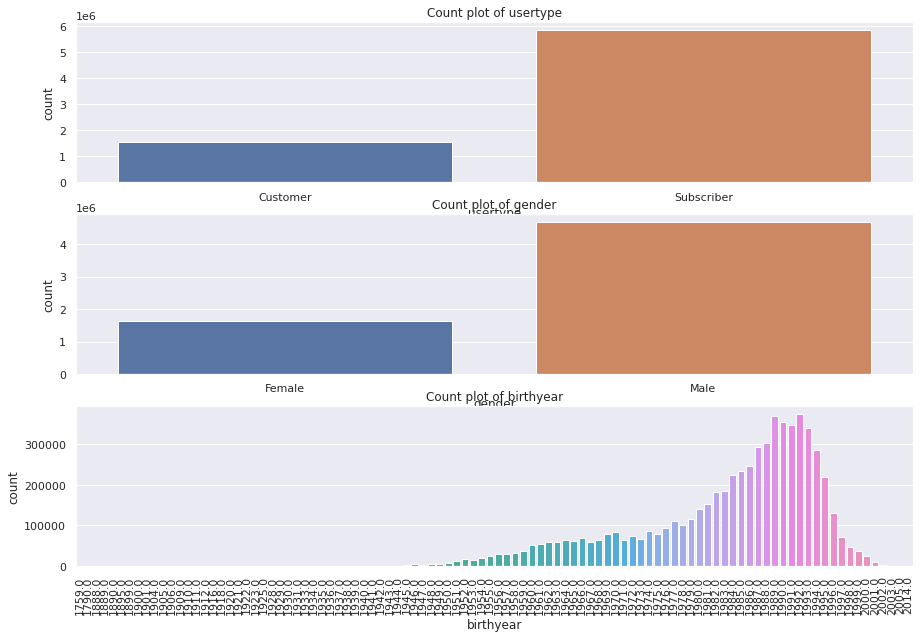

In [27]:
plt.figure(figsize=(15,10))
vars_to_look = ['usertype','gender','birthyear']
for i, var in enumerate(vars_to_look):
    plt.subplot(3,1,i+1)
    if i ==2:
        plt.xticks(rotation = 90)
    sns.countplot(trips[var])
    plt.title("Count plot of " + var)    

### 2. Male vs Female
- Average duration of trips male vs female
- Average distance of trip male vs female
- Distribution of subscriber vs customer for male and female

In [28]:
# Add a new column to calculate trip duration in minutes
trips['tripduration'] = (trips['tripduration'] / 60)

#### Average duration of trips male vs female

<strong style="color:blue">QUESTION: </strong>
What is the average duration of trips by  males vs. average duration of trips by females?

In [29]:
trips.groupby('gender')[['tripduration']].mean()

,tripduration
gender,
Female,20.423397
Male,15.661089


In [30]:
trips.groupby('gender')[['tripduration']].count()

,tripduration
gender,
Female,1616714
Male,4682661


**<p style='color:red'>Takeaway: </p>** Women take less trips than men, but women's average trip duration is about 5 minutes longer than men's average trip duration (in minutes).

#### Average distance of trip, male vs female

<strong style="color:blue">QUESTION: </strong>
What is the average minimum distance ridden (station trip started to station trip ended) of trips of males and how does it compare against the average distance ridden of trips by females?

In [31]:
def min_dist_traveled(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles

In [32]:
# Calculate distance between stations to get the minimum distance traveled of each trip
trips['min_dist_traveled'] = min_dist_traveled(trips['from_latitude'].values, trips['from_longitude'].values, trips['to_latitude'].values, trips['to_longitude'].values)

In [33]:
# Change the datatype of min_dist_traveled to float as its a numeric value
trips['min_dist_traveled'] = trips['min_dist_traveled'].astype('float')

In [34]:
trips.groupby('gender')[['min_dist_traveled']].mean()

,min_dist_traveled
gender,
Female,2.119805
Male,1.893282


#### Distribution of Subscriber vs Customer for Male and Female

<strong style="color:blue">QUESTION: </strong>
Of all trips for 2018 and 2019 how many are male/female customers and how many are male/female subscribers?

In [35]:
trips.groupby(['usertype','gender'])[['trip_id']].size().reset_index().rename(columns={'usertype':'User Type','gender':'Gender',0:'Count'})

,User Type,Gender,Count
0,Customer,Female,180374
1,Customer,Male,287404
2,Subscriber,Female,1436340
3,Subscriber,Male,4395257


### 3. Popular Stations To and From

<strong style="color:blue">QUESTION: </strong>
What are the most popular stations where trips begin/start at and what are the most popular stations of trips to end/finish at?

In [36]:
trips.groupby(['from_station_name'])[['trip_id']].count().sort_values(by='trip_id', ascending=False)

,trip_id
from_station_name,
Streeter Dr & Grand Ave,134927
Canal St & Adams St,117043
Clinton St & Madison St,101600
Clinton St & Washington Blvd,96822
Lake Shore Dr & Monroe St,85978
...,...
Oak Park Ave & Harrison St,3
Humphrey Ave & Ontario St,2
Special Events,1


In [37]:
# Map the count of trips by "FROM" station 
from_trips_count = trips.groupby(['from_longitude','from_latitude'])[['trip_id']].size().reset_index().rename(columns={0:'Count'}).sort_values(by='Count', ascending=False)
from_trips_count.reset_index(inplace=True)
from_trips_count['Count'] = from_trips_count.Count.astype('float')

folium_map = folium.Map(location=[41.88, -87.64],
                        zoom_start=13.5,
                        tiles="OpenStreetMap")

for i in range(0,len(from_trips_count)):
    marker = folium.CircleMarker(location=[from_trips_count["from_latitude"][i],from_trips_count["from_longitude"][i]],radius=from_trips_count['Count'][i] / 5000,color="blue",fill=True)
    marker.add_to(folium_map)

folium_map

In [38]:
trips.groupby(['to_station_name'])[['trip_id']].count().sort_values(by='trip_id', ascending=False)

,trip_id
to_station_name,
Streeter Dr & Grand Ave,159944
Canal St & Adams St,109306
Clinton St & Washington Blvd,98324
Clinton St & Madison St,97379
Lake Shore Dr & North Blvd,78653
...,...
BBB ~ Divvy Parts Testing,6
Humphrey Ave & Ontario St,6
TS ~ DIVVY PARTS TESTING,2


In [39]:
# Map the count of trips by "TO" station
to_trips_count = trips.groupby(['to_longitude','to_latitude'])[['trip_id']].size().reset_index().rename(columns={0:'Count'}).sort_values(by='Count', ascending=False)
to_trips_count.reset_index(inplace=True)
to_trips_count['Count'] = to_trips_count.Count.astype('float')

folium_map = folium.Map(location=[41.88, -87.64],
                        zoom_start=13.5,
                        tiles="OpenStreetMap")

for i in range(0,len(to_trips_count)):
    marker = folium.CircleMarker(location=[to_trips_count["to_latitude"][i],to_trips_count["to_longitude"][i]],radius=from_trips_count['Count'][i] / 5000,color="orange",fill=True)
    marker.add_to(folium_map)

folium_map

In [40]:
# Get a list of stations ordered by docks in service
stations[stations['Status'] == 'In Service'].sort_values(by='Docks in Service', ascending=False).head(30)

,ID,Station Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location
338,195,Columbus Dr & Randolph St,55,55,In Service,41.884728,-87.619521,"(41.884728, -87.619521)"
559,3,Shedd Aquarium,55,55,In Service,41.867226,-87.615355,"(41.86722595682, -87.6153553902)"
348,344,Ravenswood Ave & Lawrence Ave,47,47,In Service,41.969090,-87.674237,"(41.96909, -87.674237)"
96,75,Canal St & Jackson Blvd,47,47,In Service,41.877245,-87.639366,"(41.877245, -87.639366)"
668,192,Canal St & Adams St,47,47,In Service,41.879255,-87.639904,"(41.879255, -87.639904)"
648,90,Millennium Park,47,47,In Service,41.881032,-87.624084,"(41.8810317, -87.62408432)"
652,48,Larrabee St & Kingsbury St,43,43,In Service,41.897764,-87.642884,"(41.897764, -87.642884)"
358,623,Michigan Ave & 8th St,43,43,In Service,41.872773,-87.623981,"(41.872773, -87.623981)"
563,43,Michigan Ave & Washington St,43,43,In Service,41.883984,-87.624684,"(41.8839840647265, -87.6246839761734)"
118,255,Indiana Ave & Roosevelt Rd,39,39,In Service,41.867888,-87.623041,"(41.867888, -87.623041)"


In [41]:
# Map the count station docks in service
map_df = stations[['Longitude','Latitude','Docks in Service']]#[['trip_id']].size().reset_index().rename(columns={0:'Count'}).sort_values(by='Count', ascending=False)
map_df_top10 = stations[['Longitude','Latitude','Docks in Service']].sort_values(by='Docks in Service', ascending=False).head(5).reset_index()

folium_map = folium.Map(location=[41.88, -87.64],
                        zoom_start=13.5,
                        tiles="OpenStreetMap")

for i in range(0,len(map_df)):
    marker = folium.CircleMarker(location=[map_df["Latitude"][i],map_df["Longitude"][i]],radius=map_df['Docks in Service'][i] / 3,color="blue",fill=True)
    marker.add_to(folium_map)

for i in range(0,len(map_df_top10)):
    marker = folium.CircleMarker(location=[map_df_top10["Latitude"][i],map_df_top10["Longitude"][i]],radius=map_df_top10['Docks in Service'][i] / 3,color="red",fill=True)
    marker.add_to(folium_map)

folium_map

------

### 4. Trips by time of day

<strong style="color:blue">QUESTION: </strong>
Can we confirm that trip count is highes during "peak" hours?

In [42]:
# Convert the existing columns to a datetime datatype
trips['start_time'] = pd.to_datetime(trips['start_time'], format = '%Y-%m-%d %H:%M:%S')
trips['end_time'] = pd.to_datetime(trips['end_time'], format = '%Y-%m-%d %H:%M:%S')

# create new columns based off the start time 
trips['start_year'], trips['start_month'] = trips['start_time'].dt.year, trips['start_time'].dt.month
trips['start_day_of_week'] = trips['start_time'].dt.weekday
trips['start_weekday'] = trips['start_time'].dt.day_name()
trips['start_hour_of_day'] = trips['start_time'].dt.hour

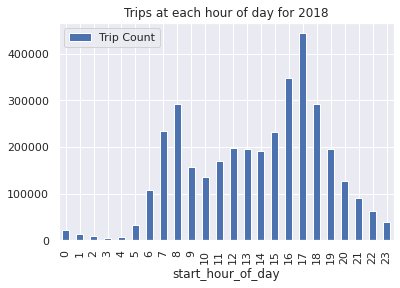

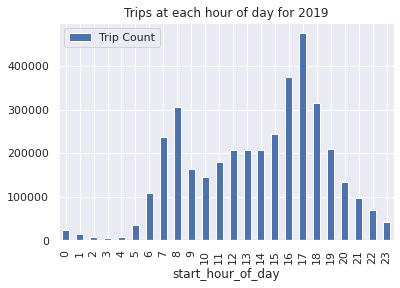

In [43]:
graph_list = [2018,2019]

for i in graph_list:
    graph_df = trips
    graph_df = graph_df[graph_df['start_year'] == i]
    graph_df = graph_df.groupby(['start_hour_of_day'])[['trip_id']].size().reset_index().rename(columns={0:'Trip Count'})
    plot = graph_df.plot.bar(x='start_hour_of_day', title=f'Trips at each hour of day for {i}')

-------
Looking at data for weekends only

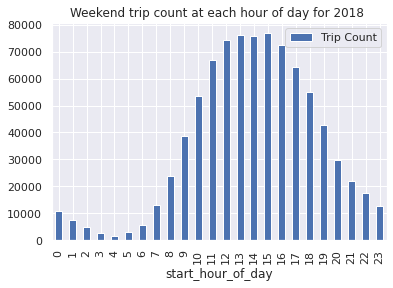

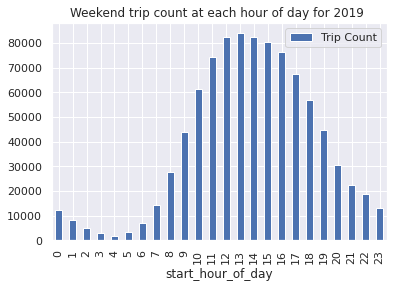

In [44]:
graph_list = [2018,2019]

for i in graph_list:
    graph_df = trips
    graph_df = graph_df[(graph_df['start_year'] == i) & (graph_df['start_day_of_week'] > 4)]
    graph_df = graph_df.groupby(['start_hour_of_day'])[['trip_id']].size().reset_index().rename(columns={0:'Trip Count'})
    plot = graph_df.plot.bar(x='start_hour_of_day', title=f'Weekend trip count at each hour of day for {i} ')

------------
Looking at data for weekdays

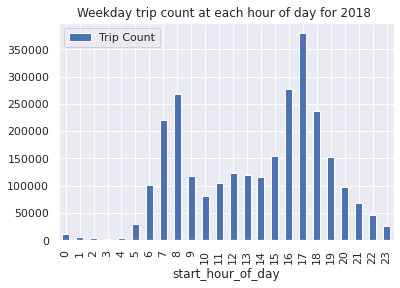

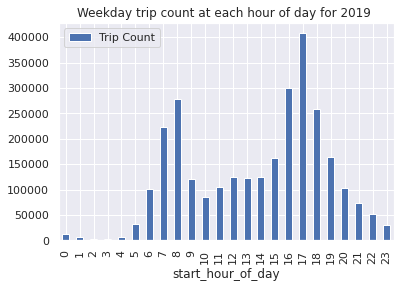

In [45]:
graph_list = [2018,2019]

for i in graph_list:
    graph_df = trips
    graph_df = graph_df[(graph_df['start_year'] == i) & (graph_df['start_day_of_week'] < 5)]
    graph_df = graph_df.groupby(['start_hour_of_day'])[['trip_id']].size().reset_index().rename(columns={0:'Trip Count'})
    plot = graph_df.plot.bar(x='start_hour_of_day', title=f'Weekday trip count at each hour of day for {i} ')

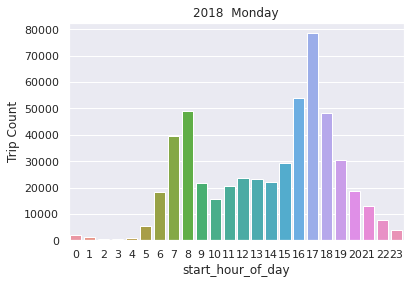

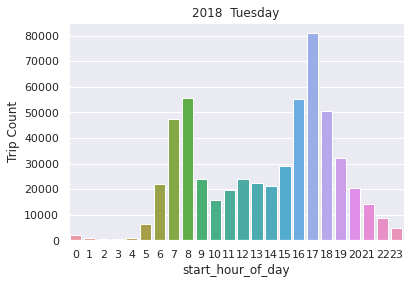

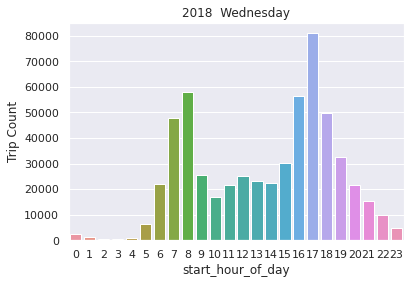

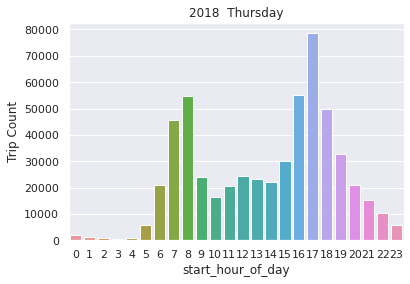

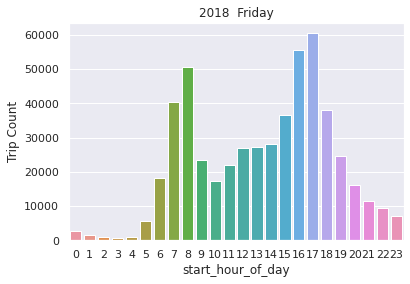

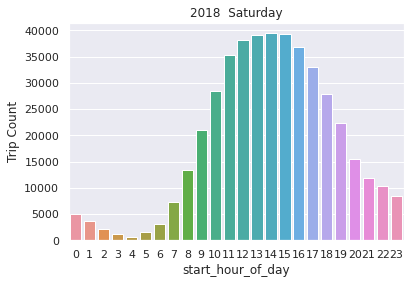

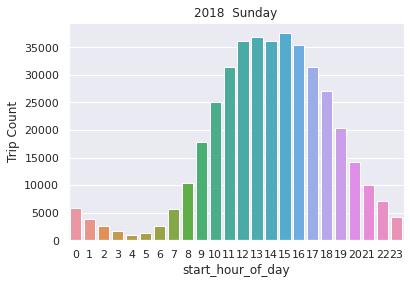

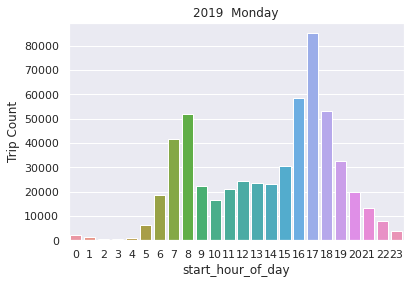

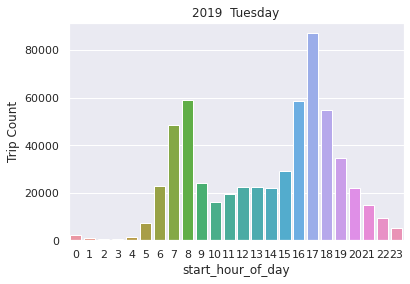

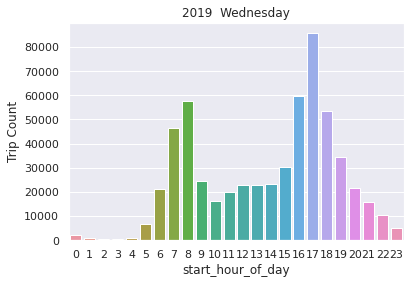

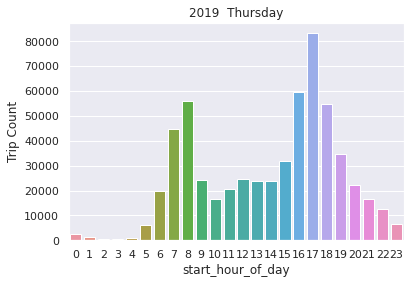

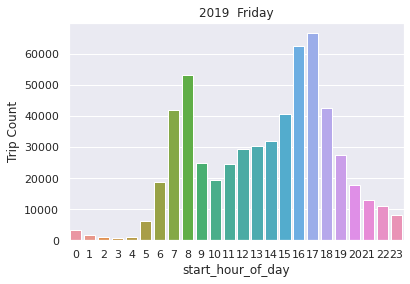

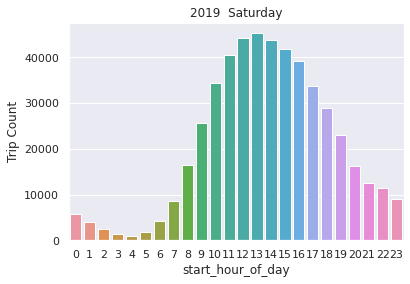

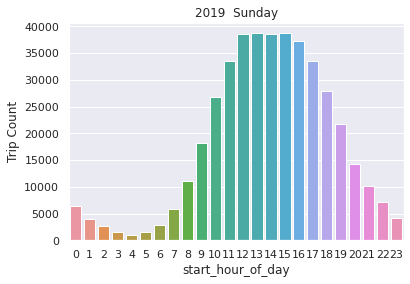

In [46]:
graph_list = [2018,2019]
day_of_week_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

for i in graph_list:
    for day in day_of_week_list:
        graph_df = trips
        graph_df = graph_df[(graph_df['start_year'] == i) & (graph_df['start_weekday'] == day)]
        graph_df = graph_df.groupby(['start_hour_of_day'])[['trip_id']].size().reset_index().rename(columns={0:'Trip Count'})
        sns.barplot(data=graph_df, x='start_hour_of_day', y='Trip Count')
        plt.title(f'{i}  {day}')
        plt.show()

### 5. Trips by month (season)

<strong style="color:blue">QUESTION: </strong>
Can we confirm the theory that trip counts are highest during spring/summer months in Chicago?

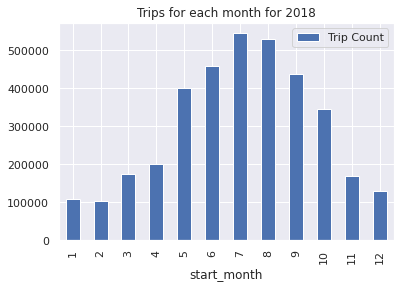

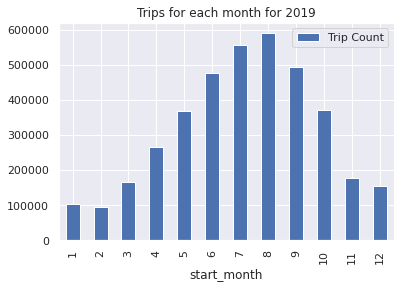

In [47]:
graph_list = [2018,2019]

for i in graph_list:
    graph_df = trips
    graph_df = graph_df[graph_df['start_year'] == i]
    graph_df = graph_df.groupby(['start_month'])[['trip_id']].size().reset_index().rename(columns={0:'Trip Count'})
    plot = graph_df.plot.bar(x='start_month', title=f'Trips for each month for {i}')

### 6. Trips of Subscribers vs Customer

<strong style="color:blue">QUESTION: </strong>
What is the difference of trip counts of Subscribers vs Customers?

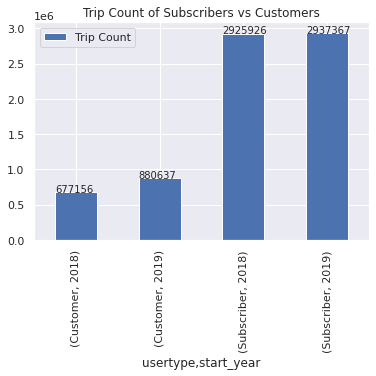

In [48]:
graph_df = trips
graph_df = graph_df.groupby(['usertype','start_year'])[['trip_id']].size().reset_index().set_index(['usertype','start_year']).rename(columns={0:'Trip Count'})
plot = graph_df.plot.bar(title='Trip Count of Subscribers vs Customers')

for p in plot.patches:
    plot.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))

### 7. Difference in trip count by weekends vs weekdays?

<strong style="color:blue">QUESTION: </strong>
What is the difference in tripcount of weekends vs weekdays?

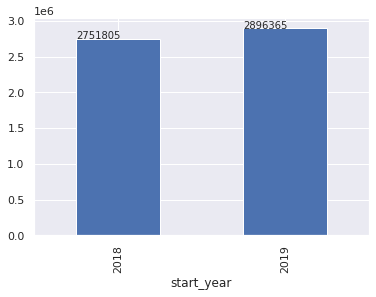

In [49]:
graph_df = trips
graph_df = graph_df[graph_df['start_day_of_week'] < 5]
graph_df = graph_df.groupby('start_year')[['trip_id']].size()
plot = graph_df.plot.bar()
for p in plot.patches:
    plot.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))

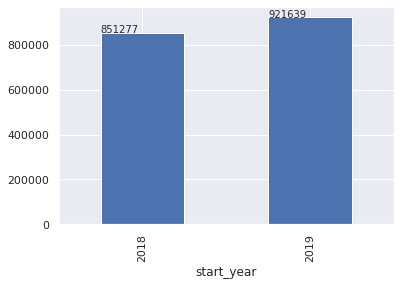

In [50]:
graph_df = trips
graph_df = graph_df[(graph_df['start_day_of_week'] > 4)]
graph_df = graph_df.groupby('start_year')[['trip_id']].size()
plot = graph_df.plot.bar()
for p in plot.patches:
    plot.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))

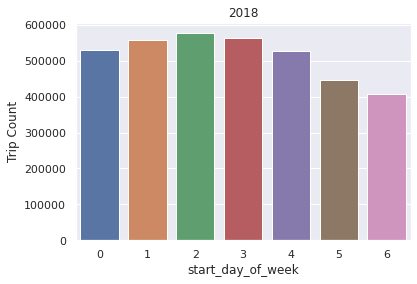

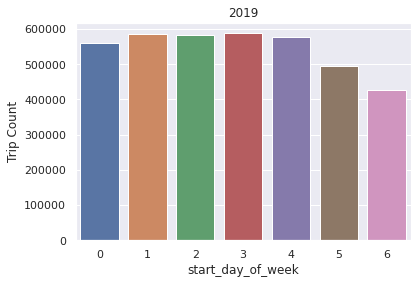

In [51]:
graph_list = [2018,2019]

for x, year in enumerate(graph_list):
    graph_df = trips
    graph_df = graph_df[(graph_df['start_year'] == year)]
    graph_df = graph_df.groupby(['start_day_of_week'])[['trip_id']].size().reset_index().rename(columns={0:'Trip Count'})
    sns.barplot(data=graph_df, x='start_day_of_week', y='Trip Count')
    plt.title(f'{year}')
    plt.show()

###  8. Distribution of Trips by subscriber age?

<strong style="color:blue">QUESTION: </strong>
What is the average age of Divvy riders for 2018 and 2019?

In [52]:
# Add a new column for rider_age at time of trip 
trips['rider_age'] = trips['start_year'] - trips['birthyear']

Text(0.5, 1.0, 'Count plot of rider_age')

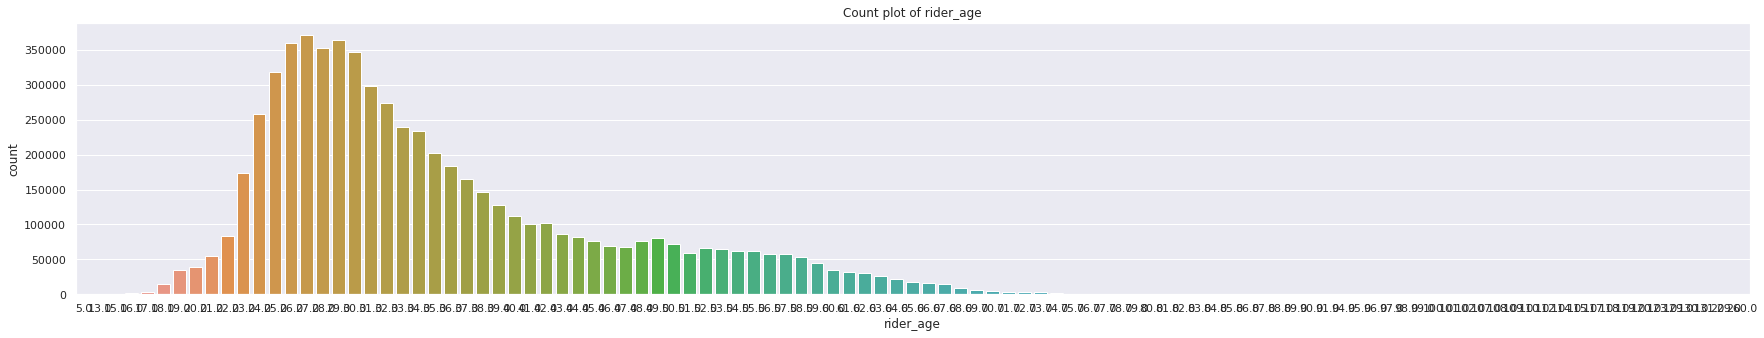

In [53]:
plt.figure(figsize=(30,5))
plot = sns.countplot(trips['rider_age'])
plt.title("Count plot of rider_age")

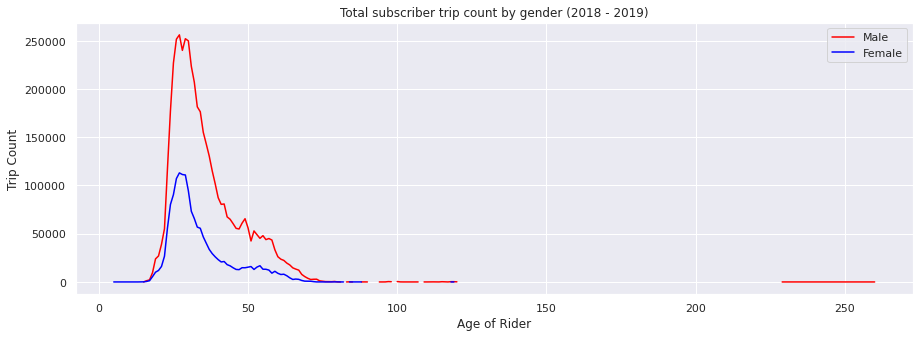

In [54]:
# Get Dataframe of gender, rider age, and trip count
graph_df = trips[trips['usertype'] == 'Subscriber']
graph_df = trips.groupby(['gender','rider_age'])[['trip_id']].count().reset_index().rename(columns={'trip_id':'Trip_Count'})

# Get the series for each gender to plot
male_age = graph_df.loc[graph_df['gender'] == 'Male',['rider_age']].to_numpy()
male_trip_count = graph_df.loc[graph_df['gender'] == 'Male',['Trip_Count']].to_numpy()

female_age = graph_df.loc[graph_df['gender'] == 'Female',['rider_age']].to_numpy()
female_trip_count = graph_df.loc[graph_df['gender'] == 'Female',['Trip_Count']].to_numpy()

# Plot data
plt.figure(figsize=(15, 5))
plt.plot(male_age, male_trip_count,c='red', label='Male')
plt.plot(female_age, female_trip_count,c='blue', label='Female')
plt.xlabel('Age of Rider')
plt.ylabel('Trip Count')
plt.title('Total subscriber trip count by gender (2018 - 2019)')
plt.legend()
plt.show()

### 9. Distribution of trips over 45 mins vs under

<strong style="color:blue">QUESTION: </strong>
What percentage of trips are over 45 mins vs under 45 mins?

In [56]:
total_trip_count = trips.trip_id.size
total_trips_over_45 = trips[trips['tripduration'] > 45].trip_id.size

print(f'{(total_trips_over_45 / total_trip_count) * 100} % of total trips went over the 45 min time, that is {total_trips_over_45} trips over 45 min overall')

6.413131447338031 % of total trips went over the 45 min time, that is 475924 trips over 45 min overall


#### Subscribers vs. Customers

<strong style="color:blue">QUESTION: </strong>
Does the percentage of trips over 45 mins vary by usertype?

In [57]:
# Get Subscriber Ratio
total_trip_count_subscriber = trips[trips['usertype'] == 'Subscriber'].trip_id.size
total_trips_over_45_subscriber = trips[(trips['usertype'] == 'Subscriber') & (trips['tripduration'] > 45)].trip_id.size
subscriber_ratio = ((total_trips_over_45_subscriber / total_trip_count_subscriber) * 100)

print('{:0.3f} % of total trips by subscribers were over 45 min, that is {:0.0f} trips over 45 min overall'.format(subscriber_ratio, total_trips_over_45_subscriber))

# get customer ratio
total_trip_count_customer = trips[trips['usertype'] == 'Customer'].trip_id.size
total_trips_over_45_customer = trips[(trips['usertype'] == 'Customer') & (trips['tripduration'] > 45)].trip_id.size
customer_ratio = ((total_trips_over_45_customer / total_trip_count_customer) * 100)

print('{:0.2f} % of total trips by customers were over 45 min, that is {:0.0f} trips over 45 min overall'.format(customer_ratio,total_trips_over_45_customer))

0.943 % of total trips by subscribers were over 45 min, that is 55280 trips over 45 min overall
27.00 % of total trips by customers were over 45 min, that is 420644 trips over 45 min overall


#### Male vs. Female

<strong style="color:blue">QUESTION: </strong>
Does the percentage of trips over 45 mins vary by gender?

In [59]:
# Get Subscriber Ratio
def get_ratio_trip(column1, value, column2, threshold):
    method_total_trip_count = trips[trips[column1] == value].trip_id.size
    method_total_trips_over_threshold = trips[(trips[column1] == value) & (trips[column2] > threshold)].trip_id.size
    method_ratio = ((method_total_trips_over_threshold /method_total_trip_count) * 100)
    print(f'{method_ratio:.2f} % of trips for {value} were over {threshold} {column2}, that is {method_total_trips_over_threshold} total trips')

# Call the method passing the Male and Female 
get_ratio_trip('gender','Male','tripduration',30)
get_ratio_trip('gender','Female','tripduration',30)
print('\n')
get_ratio_trip('gender','Male','tripduration',45)
get_ratio_trip('gender','Female','tripduration',45)

6.53 % of trips for Male were over 30 tripduration, that is 305905 total trips
10.76 % of trips for Female were over 30 tripduration, that is 173924 total trips


2.06 % of trips for Male were over 45 tripduration, that is 96563 total trips
4.10 % of trips for Female were over 45 tripduration, that is 66235 total trips


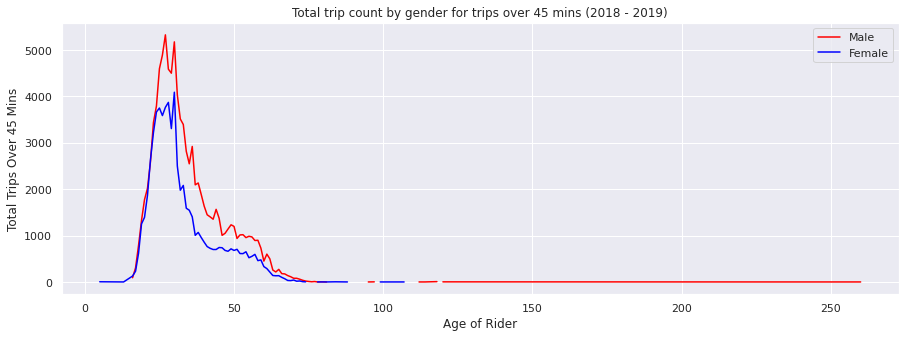

In [61]:
# Get Dataframe of gender, rider age, and trip count
graph_df = trips[trips['tripduration'] > 45]
graph_df = graph_df.groupby(['gender','rider_age'])[['trip_id']].count().reset_index().rename(columns={'trip_id':'Trip_Count'})

# Get the series for each gender to plot
male_age = graph_df.loc[graph_df['gender'] == 'Male',['rider_age']].to_numpy()
male_trip_count = graph_df.loc[graph_df['gender'] == 'Male',['Trip_Count']].to_numpy()

female_age = graph_df.loc[graph_df['gender'] == 'Female',['rider_age']].to_numpy()
female_trip_count = graph_df.loc[graph_df['gender'] == 'Female',['Trip_Count']].to_numpy()

# Plot data
plt.figure(figsize=(15, 5))
plt.plot(male_age, male_trip_count,c='red', label='Male')
plt.plot(female_age, female_trip_count,c='blue', label='Female')
plt.xlabel('Age of Rider')
plt.ylabel('Total Trips Over 45 Mins')
plt.title('Total trip count by gender for trips over 45 mins (2018 - 2019)')
plt.legend()
plt.show()

In [60]:
# Call the method passing the Year
get_ratio_trip('start_year',2018,'tripduration',30)
get_ratio_trip('start_year',2019,'tripduration',30)
print('\n')
get_ratio_trip('start_year',2018,'tripduration',45)
get_ratio_trip('start_year',2019,'tripduration',45)

12.56 % of trips for 2018 were over 30 tripduration, that is 452384 total trips
13.85 % of trips for 2019 were over 30 tripduration, that is 528687 total trips


6.27 % of trips for 2018 were over 45 tripduration, that is 225772 total trips
6.55 % of trips for 2019 were over 45 tripduration, that is 250152 total trips


## Additional Exploration

1. Correlation Matrix
2. Map of station use
    - Start and End - Weekdays
    - Start and End - Weekends

### Correlation matrix

<strong style="color:blue">QUESTION: </strong>
What is the correlation between columns of the dataframe?

In [62]:
# adding a hue/color to the pandas.corr() function output, not a map but a cool way to easily visualize correlation
correlation = trips.corr()
correlation.style.background_gradient(cmap='coolwarm')

,trip_id,bikeid,tripduration,from_station_id,to_station_id,birthyear,gender_cat,usertype_cat,from_docks_in_service,from_latitude,from_longitude,to_docks_in_service,to_latitude,to_longitude,min_dist_traveled,start_year,start_month,start_day_of_week,start_hour_of_day,rider_age
trip_id,1.000000,0.000373,0.000166,0.000585,0.000538,-0.000222,0.000421,0.000605,-0.000806,-0.000073,-0.000554,-0.000238,-0.000380,0.000154,-0.000513,0.000167,-0.000305,-0.000199,-0.001320,0.000219
bikeid,0.000373,1.000000,0.000059,-0.000487,-0.000435,0.000364,-0.000410,-0.000202,0.000015,0.000211,-0.000334,0.000049,0.000120,-0.000157,-0.000305,0.002777,-0.000514,0.000198,-0.000361,-0.000243
tripduration,0.000166,0.000059,1.000000,-0.000675,0.000103,0.002959,-0.027232,-0.033395,0.001898,-0.003303,0.006378,-0.001070,-0.002286,0.002824,0.005847,0.000562,0.000834,0.007602,0.002228,-0.002829
from_station_id,0.000585,-0.000487,-0.000675,1.000000,0.100498,0.005940,0.041880,0.058722,-0.154394,0.266724,-0.263429,-0.078255,0.055165,-0.095841,0.070989,0.003111,0.003044,0.004274,-0.026092,-0.005842
to_station_id,0.000538,-0.000435,0.000103,0.100498,1.000000,0.006861,0.041633,0.059788,-0.077686,0.061014,-0.091326,-0.176599,0.281637,-0.278820,0.068510,0.002873,0.004136,-0.000100,0.053041,-0.006788
birthyear,-0.000222,0.000364,0.002959,0.005940,0.006861,1.000000,-0.074249,-0.108833,-0.072346,0.028304,-0.044496,-0.082967,0.028137,-0.045920,0.040124,0.063299,0.049867,0.063498,0.098261,-0.998953
gender_cat,0.000421,-0.000410,-0.027232,0.041880,0.041633,-0.074249,1.000000,0.690409,-0.084130,0.020484,-0.144690,-0.087354,0.018782,-0.150101,-0.040512,0.003475,-0.011386,-0.156807,-0.056488,0.073353
usertype_cat,0.000605,-0.000202,-0.033395,0.058722,0.059788,-0.108833,0.690409,1.000000,-0.120817,0.034594,-0.183205,-0.125030,0.033874,-0.190688,-0.038152,-0.052423,-0.032935,-0.194383,-0.077223,0.103366
from_docks_in_service,-0.000806,0.000015,0.001898,-0.154394,-0.077686,-0.072346,-0.084130,-0.120817,1.000000,-0.085338,0.384644,0.171408,-0.039634,0.152049,-0.173159,-0.007985,-0.005130,-0.016030,0.022964,0.072198
from_latitude,-0.000073,0.000211,-0.003303,0.266724,0.061014,0.028304,0.020484,0.034594,-0.085338,1.000000,-0.553246,-0.045481,0.232462,-0.140905,-0.102533,0.004506,0.004596,0.019118,0.006368,-0.028088


<AxesSubplot:>

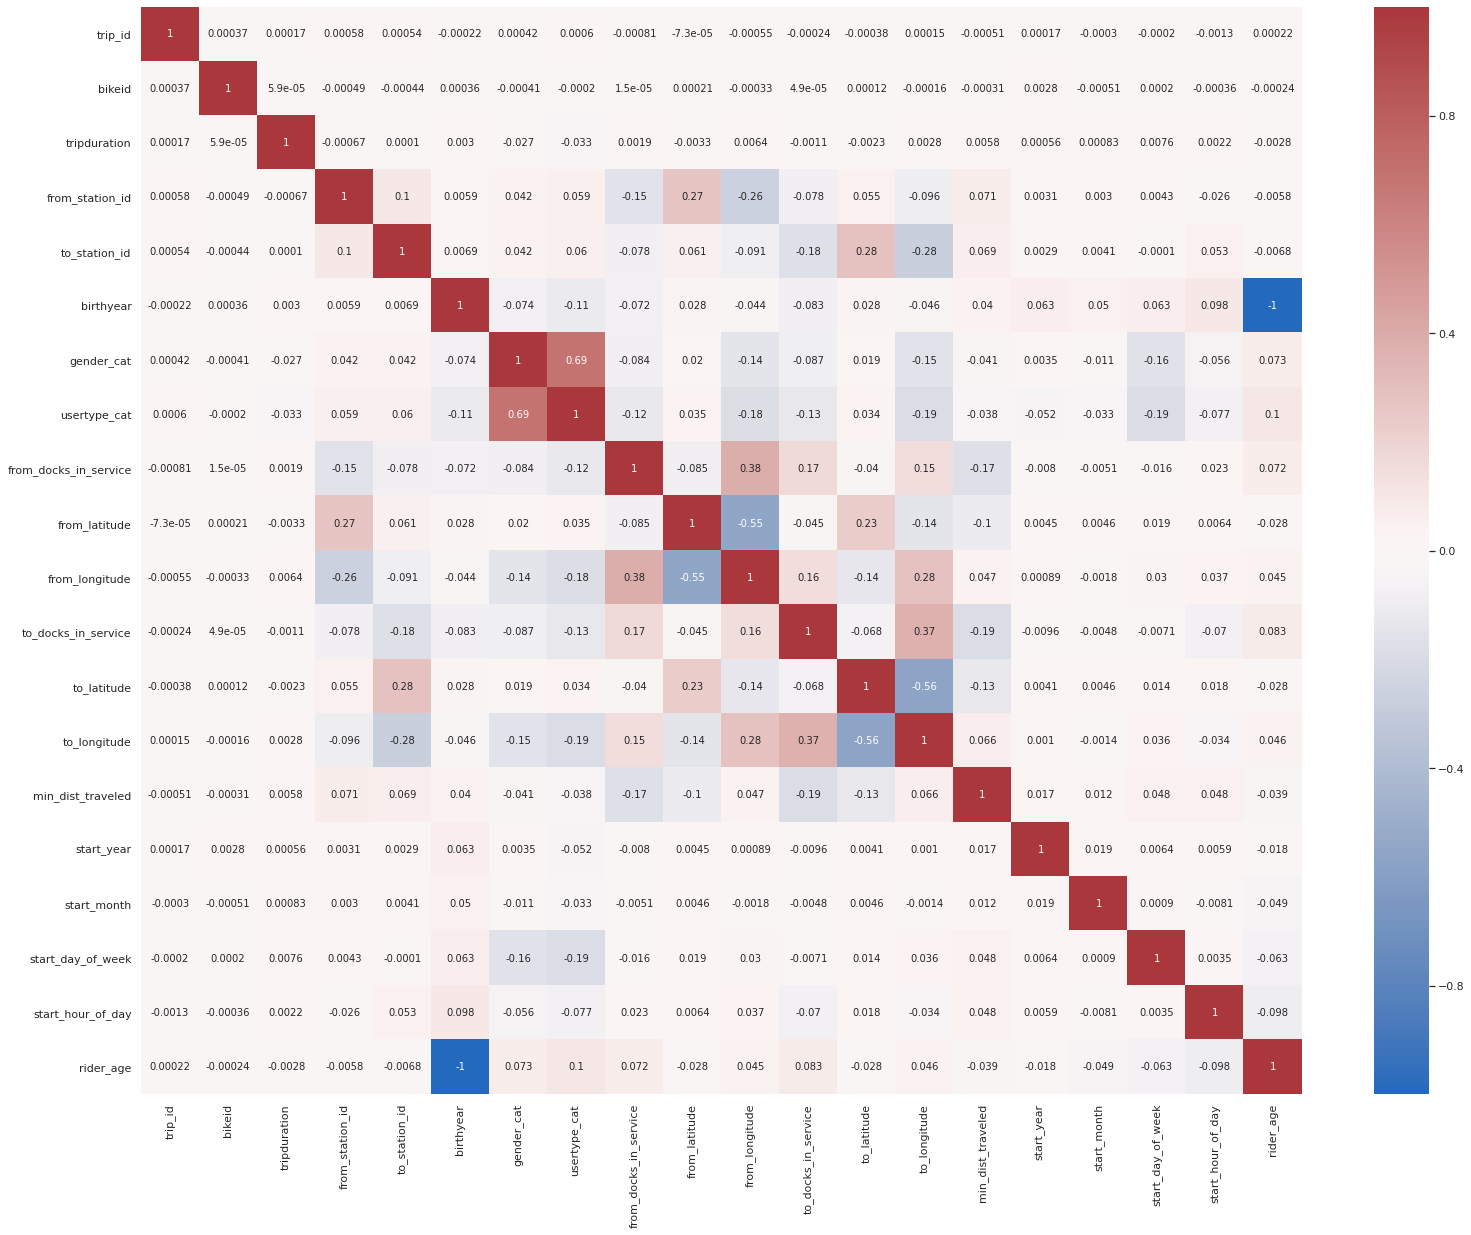

In [63]:
#Create a correlation heatmap
fig, ax = plt.subplots(figsize=(26,20)) 
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap="vlag", annot=True)

-----

### Map of station use

<strong style="color:blue">QUESTION: </strong>
Is there a difference between station trips start and end at by weekend vs weekday trips?

In [65]:
radius_var = 5000
# Create DF on weekday trips by "FROM" station
from_weekday_trip_count = trips[trips.start_day_of_week < 5].groupby(['from_longitude','from_latitude'])[['trip_id']].size().reset_index().rename(columns={0:'Count'}).sort_values(by='Count', ascending=False)
from_weekday_trip_count.reset_index(inplace=True)
from_weekday_trip_count['Count'] = from_weekday_trip_count.Count.astype('float')

# Create DF on weekend trips by FROM station
from_weekend_trip_count = trips[trips.start_day_of_week > 4].groupby(['from_longitude','from_latitude'])[['trip_id']].size().reset_index().rename(columns={0:'Count'}).sort_values(by='Count', ascending=False)
from_weekend_trip_count.reset_index(inplace=True)
from_weekend_trip_count['Count'] = from_weekend_trip_count.Count.astype('float')

folium_map = folium.Map(location=[41.88, -87.64],
                        zoom_start=13.5,
                        tiles="OpenStreetMap")


for i in range(0,len(from_weekday_trip_count)):
    marker = folium.CircleMarker(location=[from_weekday_trip_count["from_latitude"][i],from_weekday_trip_count["from_longitude"][i]],radius=from_weekday_trip_count['Count'][i] / radius_var,color="blue",fill=False)
    marker.add_to(folium_map)
for i in range(0,len(from_weekend_trip_count)):
    marker = folium.CircleMarker(location=[from_weekend_trip_count["from_latitude"][i],from_weekend_trip_count["from_longitude"][i]],radius=from_weekend_trip_count['Count'][i] / radius_var,color="red",fill=False)
    marker.add_to(folium_map)

folium_map

In [66]:
radius_var = 5000
# Create DF on weekday trips by "TO" station
to_weekday_trip_count = trips[trips.start_day_of_week < 6].groupby(['to_longitude','to_latitude'])[['trip_id']].size().reset_index().rename(columns={0:'Count'}).sort_values(by='Count', ascending=False)
to_weekday_trip_count.reset_index(inplace=True)
to_weekday_trip_count['Count'] = to_weekday_trip_count.Count.astype('float')

# Create DF on weekend trips by TO station
to_weekend_trip_count = trips[trips.start_day_of_week > 5].groupby(['to_longitude','to_latitude'])[['trip_id']].size().reset_index().rename(columns={0:'Count'}).sort_values(by='Count', ascending=False)
to_weekend_trip_count.reset_index(inplace=True)
to_weekend_trip_count['Count'] = to_weekend_trip_count.Count.astype('float')

folium_map = folium.Map(location=[41.88, -87.64],
                        zoom_start=13.5,
                        tiles="OpenStreetMap")

for i in range(0,len(to_weekday_trip_count)):
    marker = folium.CircleMarker(location=[to_weekday_trip_count["to_latitude"][i],to_weekday_trip_count["to_longitude"][i]],radius=to_weekday_trip_count['Count'][i] / radius_var,color="blue",fill=False)
    marker.add_to(folium_map)
for i in range(0,len(to_weekend_trip_count)):
    marker = folium.CircleMarker(location=[to_weekend_trip_count["to_latitude"][i],to_weekend_trip_count["to_longitude"][i]],radius=to_weekend_trip_count['Count'][i] / radius_var,color="red",fill=False)
    marker.add_to(folium_map)

folium_map

-----

## Statistical Analysis

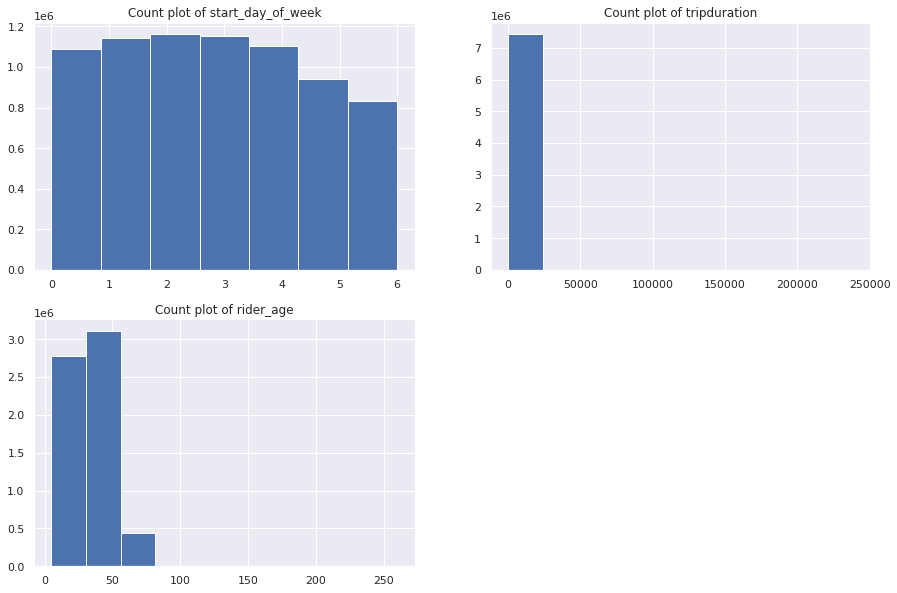

In [68]:
plt.figure(figsize=(15,10))
vars_to_look = ['start_day_of_week','tripduration','rider_age']
for i, var in enumerate(vars_to_look):
    plt.subplot(2,2,i+1)
    bin_count = trips[var].nunique()#.astype(int)
    if bin_count > 100:
        bin_count = 10
    plt.hist(trips[var], bins=bin_count)
    plt.title("Count plot of " + var)    

In [71]:
trips[['tripduration','gender_cat','usertype_cat','min_dist_traveled','start_hour_of_day','rider_age']].describe()

,tripduration,gender_cat,usertype_cat,min_dist_traveled,start_hour_of_day,rider_age
count,7.421086e+06,7.421086e+06,7.421086e+06,7.066549e+06,7.421086e+06,6.327126e+06
mean,2.387037e+01,4.798422e-01,7.900856e-01,1.966512e+00,1.374462e+01,3.511029e+01
std,5.492245e+02,7.428980e-01,4.072473e-01,1.960883e+00,4.720241e+00,1.090027e+01
min,1.016667e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
25%,6.716667e+00,0.000000e+00,1.000000e+00,7.131843e-01,1.000000e+01,2.700000e+01
50%,1.151667e+01,1.000000e+00,1.000000e+00,1.313746e+00,1.500000e+01,3.200000e+01
75%,2.078333e+01,1.000000e+00,1.000000e+00,2.560618e+00,1.700000e+01,4.000000e+01
max,2.389400e+05,1.000000e+00,1.000000e+00,1.519952e+01,2.300000e+01,2.600000e+02


In [72]:
def run_t_test(field, field_comparison1, field_comparison2, agg_field):
    series1 = trips[trips[field]==field_comparison1][agg_field]
    series2 = trips[trips[field]==field_comparison2][agg_field]

    mean_s1 = series1.mean()
    mean_s2 = series2.mean()
    test_result = pingouin.ttest(series1, series2)

    print(f'Mean {field_comparison1} {agg_field}: {mean_s1}')
    print(f'Mean {field_comparison2} {agg_field}: {mean_s2}')
    return test_result[['p-val','T']]

In [73]:
run_t_test('start_year',2018,2019,'min_dist_traveled')

Mean 2018 min_dist_traveled: 1.9323423223462635
Mean 2019 min_dist_traveled: 1.9988009051053734


/opt/conda/lib/python3.6/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,p-val,T
T-test,0.0,-45.051491


In [74]:
run_t_test('start_year',2018,2019,'rider_age')

Mean 2018 rider_age: 35.30902403085693
Mean 2019 rider_age: 34.925587931153835


/opt/conda/lib/python3.6/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,p-val,T
T-test,0.0,44.209547


In [75]:
run_t_test('start_year',2018,2019,'tripduration')

Mean 2018 tripduration: 23.552804187267096
Mean 2019 tripduration: 24.170057692448747


,p-val,T
T-test,0.127999,-1.522039


In [76]:
run_t_test('gender','Male','Female','min_dist_traveled')

Mean Male min_dist_traveled: 1.8932815213202934
Mean Female min_dist_traveled: 2.1198049616780006


/opt/conda/lib/python3.6/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,p-val,T
T-test,0.0,-122.990531


In [77]:
run_t_test('gender','Male','Female','rider_age')

Mean Male rider_age: 35.604770440872095
Mean Female rider_age: 33.6565799769281


/opt/conda/lib/python3.6/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,p-val,T
T-test,0.0,202.359952


In [78]:
run_t_test('gender','Male','Female','tripduration')

Mean Male tripduration: 15.661089228966173
Mean Female tripduration: 20.423397284038284


,p-val,T
T-test,2.944146e-39,-13.108734


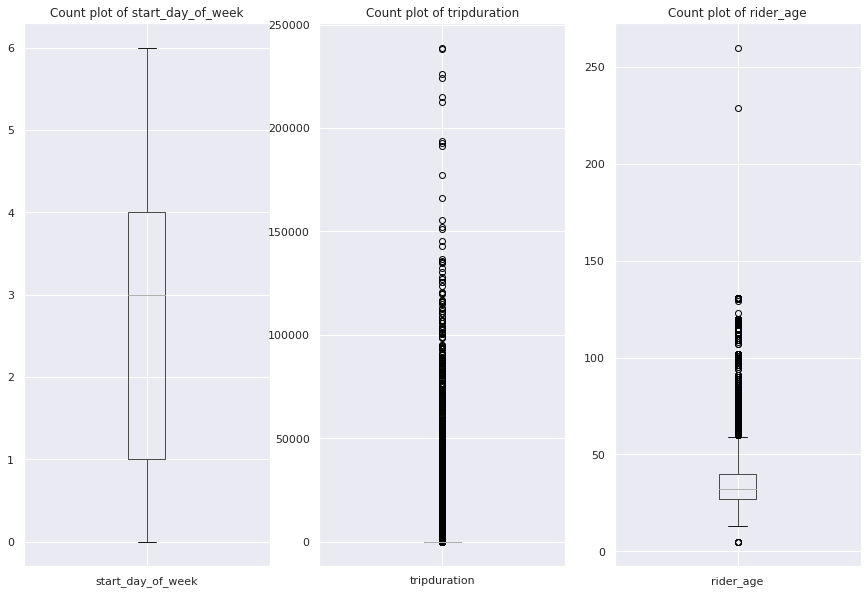

In [79]:
plt.figure(figsize=(15,10))
vars_to_look = ['start_day_of_week','tripduration','rider_age']
for i, var in enumerate(vars_to_look):
    plt.subplot(1,3,i+1)
    trips.boxplot(column=var)
    plt.title("Count plot of " + var)    

## Extract Data for Visualization

In [80]:
trips.to_csv('Cleaned_Data/trips.csv', index=False) 